## Import

In [21]:
import random
import pandas as pd
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.models as models

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

torch.backends.cudnn.benchmark = True
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
NVIDIA GeForce RTX 3070


In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [23]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':20,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}

## Fixed RandomSeed

In [24]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [25]:
df = pd.read_csv('./train.csv')
df.head()

,img_id,img_path,airplane,airport,bare soil,baseball diamond,basketball court,beach,bridge,buildings,...,tanks,tennis court,terrace,track,trail,transmission tower,trees,water,wetland,wind turbine
0,000L8TYE,./train/000L8TYE.jpg,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
1,0035QTK9,./train/0035QTK9.jpg,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,00470HEH,./train/00470HEH.jpg,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,004CCB2Q,./train/004CCB2Q.jpg,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,005AY4ES,./train/005AY4ES.jpg,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0


## Train / Validation Split

In [26]:
df = df.sample(frac=1) # 무작위 데이터 표본 추출 frac = 1이므로 순서 섞기 해당

train_len = int(len(df) * 0.8) # 80프로 데이터를 train data set으로 이용
train_df = df[:train_len]
val_df = df[train_len:]

In [27]:
(train_df.shape, val_df.shape)

((52396, 62), (13100, 62))

In [28]:
"""# 이미지 로드
image_gray = cv2.imread('images/plane_256x256.jpg', cv2.IMREAD_GRAYSCALE)

# 픽셀 강도의 중간값을 계산
median_intensity = np.median(image_gray)

# 중간 픽셀 강도에서 위아래 1 표준편차 떨어진 값을 임곗값으로 지정
lower_threshold = int(max(0, (1.0 - 0.33) * median_intensity))
upper_threshold = int(min(255, (1.0 + 0.33) * median_intensity))"""

"# 이미지 로드\nimage_gray = cv2.imread('images/plane_256x256.jpg', cv2.IMREAD_GRAYSCALE)\n\n# 픽셀 강도의 중간값을 계산\nmedian_intensity = np.median(image_gray)\n\n# 중간 픽셀 강도에서 위아래 1 표준편차 떨어진 값을 임곗값으로 지정\nlower_threshold = int(max(0, (1.0 - 0.33) * median_intensity))\nupper_threshold = int(min(255, (1.0 + 0.33) * median_intensity))"

## Data Preprocessing

In [29]:
def get_labels(df):
    return df.iloc[:,2:].values #label data 추출 함수 구현

train_labels = get_labels(train_df)
val_labels = get_labels(val_df)

In [30]:
(train_labels.shape, val_labels.shape) #저장위치와 id 삭제한 60열로 이루어진 label 데이터

((52396, 60), (13100, 60))

Text(0.5, 1.0, 'Sharp Image')

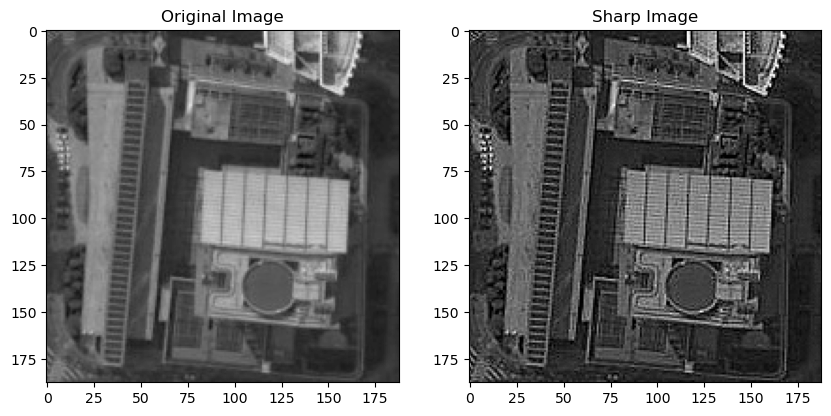

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_rgb = Image.open(train_df['img_path'].values[0]).convert("L")
#image_bgr = cv2.imread(train_df['img_path'].values[0], cv2.IMREAD_COLOR)
#image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

image_rgb = np.array(image_rgb)
# 커널 생성(대상이 있는 픽셀을 강조)
kernel1 = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# 커널 적용
image_sharp = cv2.filter2D(image_rgb, -1, kernel1)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image_rgb, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(image_sharp, cmap='gray')
ax[1].set_title('Sharp Image')

Text(0.5, 1.0, 'Sharp Image')

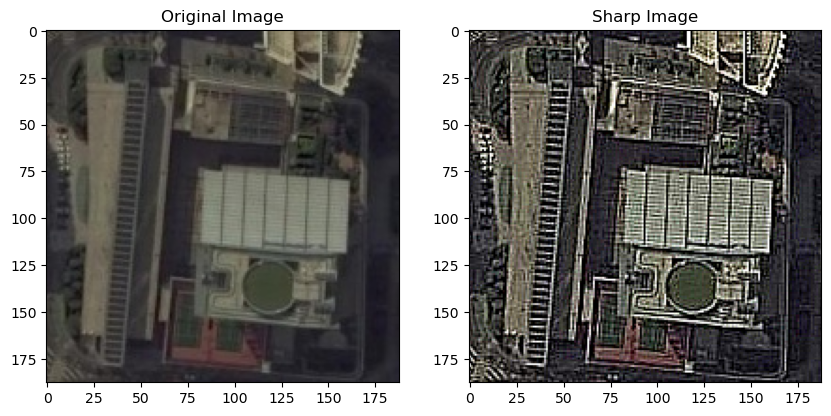

In [32]:
image_bgr = cv2.imread(train_df['img_path'].values[0], cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# 커널 생성(대상이 있는 픽셀을 강조)
kernel2 = np.array([[-1, -1, -1],
                   [-1, 9, -1],
                   [-1, -1, -1]])
# 커널 적용
image_sharp = cv2.filter2D(image_rgb, -1, kernel2)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image_rgb, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(image_sharp, cmap='gray')
ax[1].set_title('Sharp Image')

## CustomDataset

In [41]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transform=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transform = transform
        # 생성인자에 함수를 받아서 함수 생성이 가능함.
    def __getitem__(self, index):
        img_path = self.img_path_list[index]

        # PIL 이미지로 불러오기
        # image = Image.open(img_path).convert("RGB")
        image = Image.open(img_path).convert("L")
        if self.transform is not None:
            
            # 이미지 전처리과정 - sharpening
            image_data = np.array(image)
            image_sharp = cv2.filter2D(image_data, -1, kernel1)
            image = self.transform(image_sharp)
            #정의된 transform 함수를 사용하여 이미지를 전처리함.
            
        if self.label_list is not None:
            label = torch.tensor(self.label_list[index], dtype=torch.float32)
            # Multi Label Classification 문제이므로 label 데이터 또한 tensor로 변환
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)

In [42]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.Normalize(mean=[0.445], std=[0.269])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.Normalize(mean=[0.445], std=[0.269])
])

"""
train_transform = transforms.Compose([ # 아래 transform들을 순차적으로 적용함
    transforms.ToTensor(),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# transforms.Compose - 리스트 형태의 변환들을 순차적으로 적용하는 함수를 반환함.
# 함수를 생성하는 틀로 생각 (torchvision.transforms.Compose()함수)
# train_transform은 이제 위 3가지를 적용하는 함수로써 사용이 가능해짐.
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
"""
"""
transforms.ToTensor() - 이미지를 PyTorch 텐서로 변환
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                      - ImageNet 평균과 표준편차를 이용하여 이미지 정규화 진행
                      - 각 list data는 RGB 채널 각각에 대한 평균과 표준편차임
"""

'\ntransforms.ToTensor() - 이미지를 PyTorch 텐서로 변환\ntransforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])\n                      - ImageNet 평균과 표준편차를 이용하여 이미지 정규화 진행\n                      - 각 list data는 RGB 채널 각각에 대한 평균과 표준편차임\n'

In [43]:
train_dataset = CustomDataset(train_df['img_path'].values, train_labels, train_transform) # 이미지와 레이블 데이터를 가짐.
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)
# DataLoader를 활용하여 미니배치를 생성
# train_dataset의 이미지와 레이블 데이터를 활용
# train 시에는 shuffle을 활성화시켜 순서의 영향 배제
val_dataset = CustomDataset(val_df['img_path'].values, val_labels, test_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Model Define

In [44]:
from keras.models import Model
from keras.layers import Input 

In [45]:
class BaseModel(nn.Module): # nn.Module 상속받는 클래스 정의
    def __init__(self, num_classes=60):
        super(BaseModel, self).__init__()
        
        # 사전 훈련되지 않은 ResNet50 모델 로드
        resnet = models.resnet50(pretrained=False)

        # 첫 번째 컨볼루션 층을 그레이스케일 이미지용으로 수정
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=2, padding=3)

        # ResNet50의 마지막 완전 연결 층을 수정
        self.backbone = resnet
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x): # 모델에 데이터 제공 시 사용
        x = self.backbone(x) # resnet50을 통해 특징 추출
        x = F.sigmoid(self.classifier(x))   # self.classifier를 통해 클래스에 대한 점수 계산
                                            # sigmoid를 통해 각 클래스에 대한 확률로 변환
        return x

## Train

In [46]:
def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.BCELoss().to(device)
    #Binary Cross Entropy 손실함수 사용할 것

    best_val_loss = float('inf')
    best_model = None

    for epoch in range(1, CFG['EPOCHS']+1):
    # 설정한 에포크 수만큼 전체 데이터셋에 관한 train과 validation을 진행함.
        model.train() # train 설정
        train_loss = [] # loss값을 저장할 list 생성
        for imgs, labels in tqdm(iter(train_loader)):
          # 미니배치 단위로 image와 label을 받아옴.
          # BATCH_SIZE에 해당하는 image와 label을 한꺼번에 받아옴.
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            # gradient 0으로 초기화
            output = model(imgs)
            # 이미지에 대한 모델 예측 수행
            # 모델에 image를 제공했으므로, output에는 60x1 형태의 prob 데이터가 존재함.
            # 미니배치 단위로 개선을 진행했으므로 [BATCH_SIZE x 60]의 크기를 가짐
            loss = criterion(output, labels)
            # 손실함수 계산
            # BATCH_SIZE의 크기를 가지고 loss 값을 계산하고 이를 평균을 구함
            loss.backward()
            # 역전파 수행.
            optimizer.step()
            # 가중치 업데이트 수행
            train_loss.append(loss.item())
            # 각 미니배치 손실 기록

        _val_loss = validation(model, criterion, val_loader, device)

        _train_loss = np.mean(train_loss)
        # 한 에포크의 loss 평균 계산
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

        if best_val_loss > _val_loss:
            best_val_loss = _val_loss
            best_model = model

    return best_model

In [47]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            # BATCH_SIZE에 맞는 image와 label를 한꺼번에 받아옴
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            probs = model(imgs)
            # 모델에 이미지를 제공하여 prob 계산
    
            loss = criterion(probs, labels)
            # BCE Loss function으로 loss function 계산
            # 위 값은 전체 BATCH_SIZE x 60의 loss값의 평균에 해당함.
            val_loss.append(loss.item())
            # 전체 한번만 진행함.
        _val_loss = np.mean(val_loss)

    return _val_loss

## Run!!

In [ ]:
model = BaseModel()

optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])

infer_model = train(model, optimizer, train_loader, val_loader, device)

  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.20725] Val Loss : [0.18926]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.17687] Val Loss : [0.16535]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15377] Val Loss : [0.14809]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13661] Val Loss : [0.15082]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12372] Val Loss : [0.11856]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11031] Val Loss : [0.11615]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10129] Val Loss : [0.12330]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.09238] Val Loss : [0.10800]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.08480] Val Loss : [0.10916]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.07907] Val Loss : [0.10862]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.07775] Val Loss : [0.10521]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.06976] Val Loss : [0.10624]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

## Inference

In [ ]:
test = pd.read_csv('./test.csv')

In [ ]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [20]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)

            probs = model(imgs)

            probs  = probs.cpu().detach().numpy()
            predictions += probs.tolist()
    return predictions

In [21]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/1365 [00:00<?, ?it/s]

## Submission

In [22]:
submit = pd.read_csv('./sample_submission.csv')

In [23]:
submit.iloc[:,1:] = preds
submit.head()

,img_id,airplane,airport,bare soil,baseball diamond,basketball court,beach,bridge,buildings,cars,...,tanks,tennis court,terrace,track,trail,transmission tower,trees,water,wetland,wind turbine
0,000TT5XV,1.499534e-03,0.001110,0.456142,4.161345e-07,0.000176,8.121044e-05,0.000287,0.612610,0.124690,...,2.374284e-05,0.000133,0.000047,0.000670,0.000987,4.509518e-05,0.002140,0.999717,0.009315,1.669443e-05
1,0013XXDH,7.657570e-07,0.000032,0.425280,5.190450e-06,0.000001,3.061031e-05,0.000110,0.126406,0.008516,...,5.607681e-06,0.000028,0.000913,0.000068,0.337097,9.065350e-06,0.996391,0.002124,0.000126,1.184509e-04
2,001Z4YNH,1.268502e-06,0.000002,0.305856,1.953779e-05,0.000016,8.449629e-08,0.000008,0.878152,0.624970,...,7.025882e-07,0.999998,0.000001,0.000007,0.000039,8.801628e-07,0.999571,0.028573,0.000002,1.797425e-11
3,00297F36,6.759330e-04,0.002323,0.114433,7.621239e-06,0.002807,5.665358e-05,0.003661,0.967453,0.978667,...,1.423375e-03,0.000862,0.001782,0.018550,0.006759,2.823762e-03,0.853397,0.009564,0.001052,1.405077e-04
4,002GFJL0,5.881143e-05,0.001058,0.803369,4.613518e-05,0.000790,8.504193e-05,0.003295,0.660972,0.410833,...,8.349516e-05,0.000447,0.000557,0.000831,0.002131,4.458644e-04,0.068122,0.964665,0.002609,4.500003e-05


In [24]:
submit.to_csv('./baseline_submit.csv', index=False)